## Notes from Q&A Session May 7, 2020

In [1]:
from lakemodel_function import lake_problem
from ema_workbench import (Model, RealParameter, ScalarOutcome)
# instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specifiy the number of timesteps
#specify uncertainties
lake_model.uncertainties =[RealParameter('b', 0.1, 0.45),
                           RealParameter('q', 2.0, 4.5),
                           RealParameter('mean', 0.01, 0.05),
                           RealParameter('stdev', 0.001, 0.005),
                           RealParameter('delta', 0.93, 0.99)]
# set levers
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in range(lake_model.time_horizon)]
#specify outcomes
lake_model.outcomes = [ScalarOutcome('max_P'),
                      ScalarOutcome('utility'),
                      ScalarOutcome('inertia'),
                      ScalarOutcome('reliability')]

C:\Users\Carol\Anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


In [2]:
from ema_workbench import Policy, ema_logging, MultiprocessingEvaluator, SequentialEvaluator
ema_logging.log_to_stderr(ema_logging.INFO)
policy = Policy("no release", **{l.name:0 for l in lake_model.levers})
n_scenarios = 1000
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios, policy)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [3]:
maxp = outcomes['max_P']

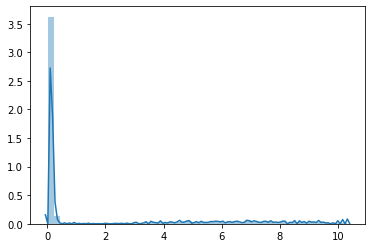

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

fig, ax = plt.subplots()
sns.distplot(maxp, ax = ax)
plt.show()

In [5]:
#Example
#ID conditions under which we fail: a high max_P is a form of faiulre
#lets see whre max pollution is higher than 0.5
import numpy as np
np.sum(maxp > 0.5)

227

In [8]:
from ema_workbench.analysis import prim
x = experiments
y = maxp > 0.5

# primalf = prim.Prim?

primlg = prim.Prim(x, y, threshold = 0.8)
box1 = primlg.find_box()

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 1000 points remaining, containing 227 cases of interest
[MainProcess/INFO] mean: 0.923728813559322, mass: 0.118, coverage: 0.4801762114537445, density: 0.923728813559322 restricted_dimensions: 3


### PRIM

Aim of PRIM is to find orthogonal subspace that has a high concentratiton of points that we are interested in 

Makes candidate boxes with concentration of points of interst and chooses the best box (stepwise iterative process)

Each of these steps is saved - i.e. peeling trajectory, so you can go back and see them (box1.show_)tradeoff(), plt.show() )

 --------------------
 
*peel_apha = controls how much data is removed at each step (default is 0.05 - i.e. 5% of data is being removed at the time)
BUT, îf you remove a small amount of data, you have less data, so you need  a stopping condition -> controlled by a max/min 

*max/min = Remove data that you have little to no interest in (default is 0.05 - i.e. 5% of the data is left, which means you can do at most 95 steps assuming everyting else is a continuous variable)

*threshold = concetration of cases of interest left in the final box after the interative removing of data (0.08  default - i e. you want a concentration or density of 80% in the final box)
^^Note: May need to set a lower threshold because you cannot make a box that meets the threshold critereia

*paste_alhpa = Exact opposite of peel alpha (default is 0.05) (after you hit the stopping conditon of min/max PRIM tries to make the box a bit larger by trying to glue back a small bit of data (0.05 deafulty - i e adds 5% of data back))

(Note: ^^Can basically forget about past_alpha because it rarely makes a difference)

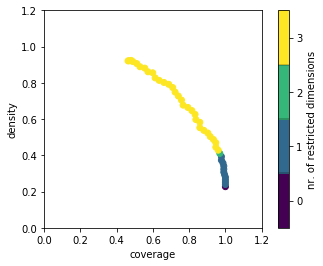

In [9]:
#Peeling Trajectory
#Each box outcome is saved (peeling trajectory - so we can go back and look at these because they are also saved)
box1.show_tradeoff()
plt.show()

In [25]:
#Inspect different points on the peeling trajectory to see the perfect balanace of tradeoffs (i.e. use box1.inspect(candiate box number))
#Example
box1.inspect(34)

#Note -1 on left hand means no restriction on lower end, and -1 on right hand means no restriction on higher end

coverage    0.612335
density     0.827381
id                34
mass           0.168
mean        0.827381
res_dim            3
Name: 34, dtype: object

        box 34                                         
           min       max                      qp values
b     0.100006  0.201061  [-1.0, 1.240715789098592e-39]
q     2.000374  4.138306   [-1.0, 0.042599154343923515]
mean  0.023137  0.049973  [4.327111525465287e-07, -1.0]



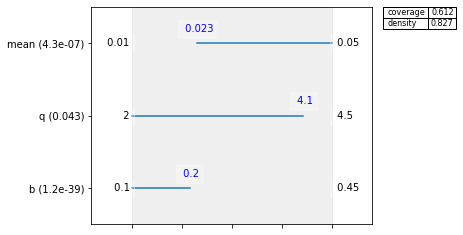

In [13]:
#Note, same info as box1.inspect() above, just a different visualisation
box1.inspect(34, style = 'graph')
plt.show()

#Note, p-values greater than 0.05 are not statisticall significant

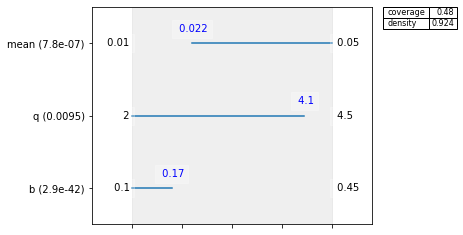

In [26]:
#Note: For final box, put no number in for candidate box (i.e. for me, last box is 43)
box1.inspect(style = 'graph')
plt.show()

In [28]:
#Interactive way to look at both the graph and the chart
#Gives same peeling trajectory as before, but interactive (requires that you have altair installed - note, the moment you import PRIM, altair is also imported, you do not need to do it manually - just make sure you have it)
#Note, sometimes this won't work for partiucalry 'nasty' datasets - but should be fine for the data used in this courss
box1.inspect_tradeoff()

alt.VConcatChart(...)

In [ ]:
#What do we do with the variables that are not significant?
#Drop the non-significant dimension (i.e. the dimension with a p-value that is greater than 0.05)
box1.inspect(style = 'graph')
box1.drop_restriction('delta in Jan example which was greater than 0.05')
box1.inspect(style = 'graph')
plt.show()

### Same Process but for Multiple Policies Example

In [29]:
#Question about what to do if yo have multiple policies also in your dataset:
#Example

n_scenarios = 1000
n_policies = 4

with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios, n_policies)


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [32]:
experiments.head()

,b,delta,mean,q,stdev,l0,l1,l10,l11,l12,...,l93,l94,l95,l96,l97,l98,l99,scenario,policy,model
0,0.205231,0.975762,0.038587,4.296666,0.003841,0.015453,0.085259,0.0511,0.05027,0.031991,...,0.037806,0.033794,0.027304,0.073189,0.003451,0.002681,0.012395,1000,0,lakeproblem
1,0.245702,0.967512,0.025659,2.221150,0.001010,0.015453,0.085259,0.0511,0.05027,0.031991,...,0.037806,0.033794,0.027304,0.073189,0.003451,0.002681,0.012395,1001,0,lakeproblem
2,0.346298,0.931431,0.034188,4.346887,0.002180,0.015453,0.085259,0.0511,0.05027,0.031991,...,0.037806,0.033794,0.027304,0.073189,0.003451,0.002681,0.012395,1002,0,lakeproblem
3,0.155935,0.966157,0.025305,3.139417,0.001023,0.015453,0.085259,0.0511,0.05027,0.031991,...,0.037806,0.033794,0.027304,0.073189,0.003451,0.002681,0.012395,1003,0,lakeproblem
4,0.310590,0.944015,0.038212,2.527866,0.002185,0.015453,0.085259,0.0511,0.05027,0.031991,...,0.037806,0.033794,0.027304,0.073189,0.003451,0.002681,0.012395,1004,0,lakeproblem


In [33]:
#ID number of unique policies
experiments.policy.unique() #Gives us 4 unique policies

array([0, 1, 2, 3], dtype=object)

In [35]:
#Scenario discovery in this dataset:

#In this particular case, the policy ID already gives us info so drop levers from experiments column

# Basically, cleaning up experiements first can help eliminate redundency 
#(reduncy is that you have only 4 policies, so the 100 columns with all of the levers with the timesteps are not intervesting, 
#you only care about the policy as a whole) (i.e. why he drops the levers for "cleaned")

cleaned = experiments.drop(columns=[l.name for l in lake_model.levers])

In [36]:
cleaned

,b,delta,mean,q,stdev,scenario,policy,model
0,0.205231,0.975762,0.038587,4.296666,0.003841,1000,0,lakeproblem
1,0.245702,0.967512,0.025659,2.221150,0.001010,1001,0,lakeproblem
2,0.346298,0.931431,0.034188,4.346887,0.002180,1002,0,lakeproblem
3,0.155935,0.966157,0.025305,3.139417,0.001023,1003,0,lakeproblem
4,0.310590,0.944015,0.038212,2.527866,0.002185,1004,0,lakeproblem
...,...,...,...,...,...,...,...,...
3995,0.385489,0.948255,0.040476,3.229883,0.001615,1995,3,lakeproblem
3996,0.285103,0.936989,0.049409,2.000678,0.002278,1996,3,lakeproblem
3997,0.211717,0.969398,0.033792,2.056013,0.001096,1997,3,lakeproblem
3998,0.323670,0.941601,0.044181,4.366671,0.002585,1998,3,lakeproblem


In [39]:
x = cleaned
y = outcomes['max_P'] > 0.5
primalg = prim.Prim(x, y, threshold = 0.8, peel_alpha = 0.1)
box1 = primalg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 4000 points remaining, containing 2818 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.386, coverage: 0.5479063165365508, density: 1.0 restricted_dimensions: 3


In [40]:
#Inspect the tradeoff (i.e. peeling trajectory)
box1.inspect_tradeoff()

alt.VConcatChart(...)

#### Note, Jan usualy removes levers before testing in order to make interpreting results easier, but this is just his preference

## Answers to questions posed at the end of Q&A

- Threshold applies to the density of the final box - (i.e. says that the density of the final box should be higher than 0.8)

- Cleaning up experiements first can help eliminate redundency (reduncy is that you have only 4 policies, so the 100 columns with all of the levers with the timesteps are not intervesting, you only care about the policy as a whole) (i.e. why he drops the levers for "cleaned")

------------------------------------------------------------------------- New Topic -------------------------------------------------------------

# Dimensional Stacking

[MainProcess/INFO] model dropped from analysis because only a single category


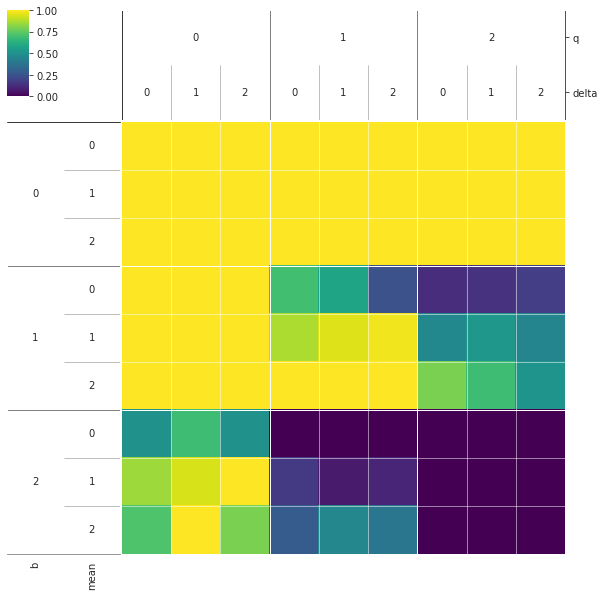

In [47]:
from ema_workbench.analysis import dimensional_stacking

x= experiments
y = outcomes['max_P'] > 2

dimensional_stacking.create_pivot_plot(x,y, nr_levels =2) #NoteL nr_levels sets number of dimensions that we are stacking, so set to 3 gives us 6 uncertainties
plt.show()

#Bright yellow, all points in particular bin are of interet
#Dark blue, no points of interst in a bin
#White means that you have not sampled anything in a region - (Note: could mean you have not sampled enough)
#q, b, delta, and mean are split into 3 intervals


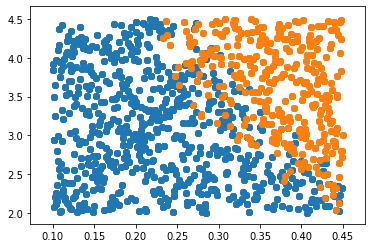

In [46]:
#Basically, dimensional stacking gives us a plot that is basically a fancy column plot
#The way dimensional stacking works is comparable to PRIM - but the difference is that dimensional stacking is a purely visual way of doing it

#Imagine that we scatter our experiemtns against one and another on the b and q dimension
fig, ax = plt.subplots()

ax.scatter(experiments.b[y], experiments.q[y])
ax.scatter(experiments.b[y==False], experiments.q[y==False])
plt.show()

#Note: blue = points of interest, orange = points not of interest

In [48]:
#Make scatter plot for 2 dimensions for the full range then with conditional of other dimension as well
#(basically we do a scatter plot of subset of the data and then doing a binning overlay) --> Basically this gives us dimensional stacking

[MainProcess/INFO] model dropped from analysis because only a single category


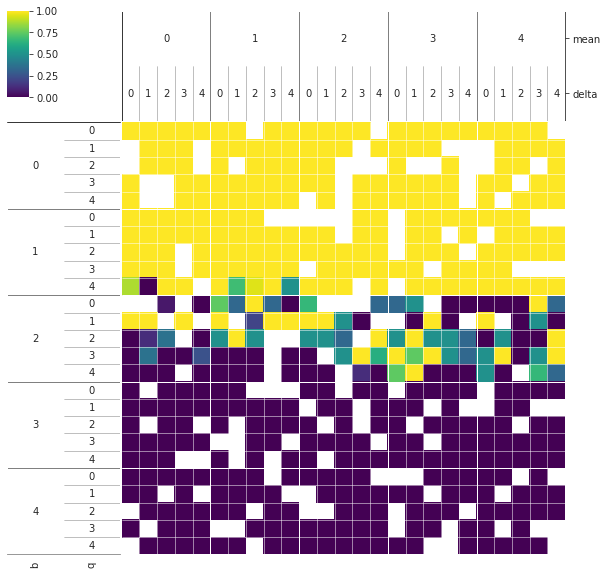

In [50]:
#Example, with a lot of yellow space, may be better to make dimensions more restrcitve
#Example:

from ema_workbench.analysis import dimensional_stacking

x= experiments
y = outcomes['max_P'] > 4

dimensional_stacking.create_pivot_plot(x,y, nr_levels =2, nbins=5) #NoteL nr_levels sets number of dimensions that we are stacking, so set to 3 gives us 6 uncertainties
plt.show()

#This plot gives a lot of white space -> so may be better to run more experiments

------------------------------------------------------------------------- New Topic -------------------------------------------------------------

### Sub Space Partitioning vs Global Sensitivity Analysis (Use both - they are complimentary and can help check one another)

Sub Space Partitioning: 
- Try to partition model input space into distinct regions that are characeristic of success or failure
- Basically given what is in my model input space, do I get a particular type of outcome?
- PRIM, scenario discorery (e.g. PRIM, CART) and n-dimensional stacking

Global Sensitivity Analysis
- (Reasons other way around from Sub Space Partitioning)
- Understanding how variation in model outputs is explained by varaition in model inputs
- Gives a different understanding of how and why different outcomes occur
- (Will not give you easy rules of subspaces like PRIM and CART do, but gives you a rank order of relevant importance of different model outcomes that you get)

------------------------------------------------------------------------- New Topic -------------------------------------------------------------